In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange
from diffusion_equation import compute_solution
from time import time
from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score
import torch
from torch import nn
from torchvision import models
from train_logic import compute_pde_residuals, create_batches, get_batch_indices, resample_collocation_points

In [2]:
def flat_the_gradient_from_loss(model, loss):
    model.zero_grad()
    loss.backward(retain_graph=True)
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().cpu().numpy().reshape(-1))
    grad_flat = np.concatenate(grads)
    return grad_flat

def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data


# Getting data from simulator

In [8]:
# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm_3sigma.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000

t_final = 3.0
dt = t_final / niter

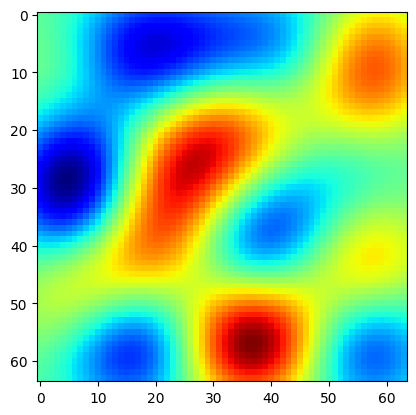

In [9]:
plt.imshow(np.log(perm))

# Read from file

In [10]:
# sim_data: pres, swat, soil
n_points = 500
sim_r = np.random.randint(0, 5000, n_points)

# 5000
sim_data = np.loadtxt("data_5k_3sigma/sim_5000.txt", dtype=np.float32)[sim_r]
x_list = np.loadtxt("data_5k_3sigma/x_5000.txt", dtype=np.float32)[sim_r]
y_list = np.loadtxt("data_5k_3sigma/y_5000.txt", dtype=np.float32)[sim_r]
t_list = np.loadtxt("data_5k_3sigma/t_5000.txt", dtype=np.float32)[sim_r]

# Convert to torch tensor

In [11]:
simulation_data = torch.tensor(sim_data).requires_grad_(True)

x = torch.tensor(x_list * dx0).requires_grad_(True)
y = torch.tensor(y_list * dx1).requires_grad_(True)
t = torch.tensor(t_list * dt).requires_grad_(True)

points = torch.stack((t, x, y), -1).requires_grad_(True).to('mps')
# points, simulation_data

# Boundary points

In [12]:
pres0_x1_points = torch.stack((t, torch.zeros_like(x), y), -1).requires_grad_(True).to('mps')
pres1_x1_points = torch.stack((t, torch.ones_like(x), y), -1).requires_grad_(True).to('mps')
swat0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True).to('mps')
soil0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True).to('mps')
u0_x2_points = torch.stack((t, x, torch.zeros_like(y)), -1).requires_grad_(True).to('mps')
u1_x2_points = torch.stack((t, x, torch.ones_like(y)), -1).requires_grad_(True).to('mps')

# Model configuration

In [17]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 3, hidden_layer = 64, number_layers = 16, output_layer = 7):
        super().__init__()
        
        activation2 = nn.Sigmoid
        activation1 = nn.ReLU
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation1()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation1()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
#         resnet = models.resnet18()
        
#         self.resnet_features = nn.Sequential(
#             resnet.layer1,   # First residual block
#             resnet.layer2,   # Second residual block
#             resnet.layer3,   # Third residual block
#             resnet.layer4    # Fourth residual block
#         )
        
#         self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
#         self.fce = nn.Linear(512, output_layer)
        
        self.act = nn.ReLU()
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        """
        function for updating neural network
        
        return:
            x - vector (pres
                        soil
                        swat
                        uoil_x,  
                        uoil_y,
                        uwat_x,  
                        uwat_y)
        """
        
        x = self.fcs(x)
        x = self.fch(x)
        
#         x = x.view(x.size(0), 64, 1, 1)
#         x = self.resnet_features(x)
        
#         x = self.adaptive_pool(x)
        
#         x = x.view(x.size(0), -1)        
        x = self.fce(x)
#         x = self.act(x)
        
        return x

class ModifiedPINN(nn.Module):
    """
    Modified MLP architecture based on Wang et al. with U-Net style connections.
    Particularly effective for capturing sharp gradients in pressure/saturation.
    
    Key improvements:
    - Modified MLP with U and V paths (proven effective for PINNs)
    - Skip connections for gradient flow
    - Separate branches for different physics (pressure vs saturation)
    - Adaptive activation functions
    """
    
    def __init__(self, input_dim=3, hidden_dim=128, num_layers=6, output_dim=7):
        super(ModifiedPINN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Modified MLP: Two parallel input branches (U and V paths)
        self.U = nn.Linear(input_dim, hidden_dim)
        self.V = nn.Linear(input_dim, hidden_dim)
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        for i in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Learnable scaling parameters for outputs
        self.pressure_scale = nn.Parameter(torch.ones(1))
        self.saturation_scale = nn.Parameter(torch.ones(2))
        self.velocity_scale = nn.Parameter(torch.ones(4))
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Xavier initialization for better gradient flow."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass with modified MLP architecture.
        
        Args:
            x: Input [batch, 7] -> (t, x, y, pwat, poil, kwat, koil)
        
        Returns:
            out: [batch, 7] -> (pres, soil, swat, uoil_x, uoil_y, uwat_x, uwat_y)
        """
        # Modified MLP: Two parallel branches
        U = torch.tanh(self.U(x))
        V = torch.tanh(self.V(x))
        
        # Element-wise multiplication (key feature of modified MLP)
        h = U * V
        
        # Pass through hidden layers with residual connections
        for i, layer in enumerate(self.hidden_layers):
            h_new = torch.tanh(layer(h))
            # Residual connection every 2 layers
            if i % 2 == 1 and i > 0:
                h = h + h_new  # Skip connection
            else:
                h = h_new
        
        # Output layer
        out = self.output_layer(h)
        
        # Split outputs
        pressure = out[:, 0:1]
        saturation_oil = out[:, 1:2]
        saturation_wat = out[:, 2:3]
        velocities = out[:, 3:7]
        
        # Apply constraints with learnable scales
        # Pressure: softplus for positivity
        pressure = F.softplus(pressure * self.pressure_scale, beta=1, threshold=20)
        
        # Saturations: sigmoid to enforce [0, 1] bounds
        saturation_oil = torch.sigmoid(saturation_oil * self.saturation_scale[0])
        saturation_wat = torch.sigmoid(saturation_wat * self.saturation_scale[1])
        
        # Enforce saturation constraint: S_o + S_w = 1
        # Normalize to ensure sum equals 1
        sat_sum = saturation_oil + saturation_wat + 1e-8
        saturation_oil = saturation_oil / sat_sum
        saturation_wat = saturation_wat / sat_sum
        
        # Velocities: can be positive or negative, use tanh scaled
        velocities = torch.tanh(velocities) * self.velocity_scale
        
        return torch.cat([pressure, saturation_oil, saturation_wat, velocities], dim=1)

# Model training

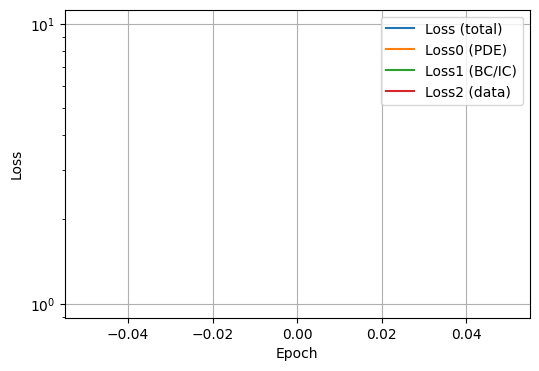

In [21]:
epochs_hist = []
loss_hist   = []
loss0_hist  = []
loss1_hist  = []
loss2_hist  = []

# ONE figure & ONE axes
fig, ax = plt.subplots(figsize=(6, 4))

(line_loss,)  = ax.plot([], [], label="Loss (total)")
(line_l0,)    = ax.plot([], [], label="Loss0 (PDE)")
(line_l1,)    = ax.plot([], [], label="Loss1 (BC/IC)")
(line_l2,)    = ax.plot([], [], label="Loss2 (data)")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.grid(True)
ax.legend()

def update_loss_plot(epoch, loss, loss0, loss1, loss2):
    # store history
    epochs_hist.append(epoch)
    loss_hist.append(loss)
    loss0_hist.append(loss0)
    loss1_hist.append(loss1)
    loss2_hist.append(loss2)

    # update line data
    line_loss.set_data(epochs_hist, loss_hist)
    line_l0.set_data(epochs_hist, loss0_hist)
    line_l1.set_data(epochs_hist, loss1_hist)
    line_l2.set_data(epochs_hist, loss2_hist)

    # rescale
    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True)
    display(fig)

In [22]:
DEVICE = 'mps'

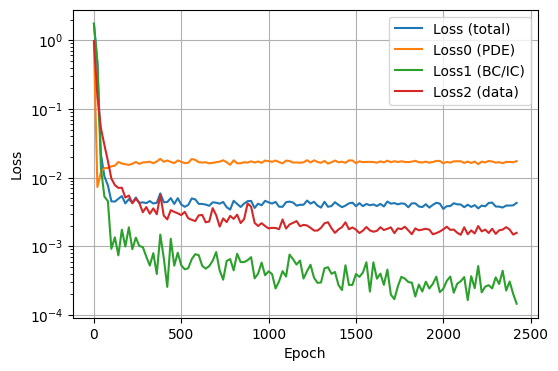

 48%|█████████████████████████████████████████████████████▊                                                         | 2425/5000 [32:32<34:32,  1.24it/s]


KeyboardInterrupt: 

In [23]:
epochs = 5_000
BATCH_SIZE = 128  
RESAMPLE_EVERY = 70

model = PINN().to(DEVICE)
# ModifiedPINN(
#    input_dim=3,
#    hidden_dim=128,  # Try 128, 256
#    num_layers=6,    # Try 5-8
#    output_dim=7
# ).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
max_dist = float('inf')

perm_vec = torch.tensor(
    perm[list(x.cpu().detach().numpy().astype(int)), 
         list(y.cpu().detach().numpy().astype(int)), -1].astype(np.float32)
).to(DEVICE)


for cur_epoch in trange(epochs):
    
    epoch_loss = 0.0
    epoch_loss0 = 0.0
    epoch_loss1 = 0.0
    epoch_loss2 = 0.0
    num_batches = 0
    
    for batch_indices in get_batch_indices(points.shape[0], BATCH_SIZE, shuffle=True):
        
        optimizer.zero_grad()
        
        points_batch = points[batch_indices].to(DEVICE)
        perm_vec_batch = perm_vec[batch_indices]
        
        r1, r2, r3_x1, r3_x2, r4_x1, r4_x2, r5, model_res = \
            compute_pde_residuals(model, points_batch, perm_vec_batch)
        
        loss0 = torch.mean(
            r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + r4_x1**2 + r4_x2**2 + r5**2
        )
        
        bc_batch_size = min(BATCH_SIZE // 4, 
                           pres0_x1_points.shape[0],
                           pres1_x1_points.shape[0],
                           soil0_x1_points.shape[0],
                           swat0_x1_points.shape[0])
        
        bc_idx_pres0 = torch.randperm(pres0_x1_points.shape[0])[:bc_batch_size]
        bc_idx_pres1 = torch.randperm(pres1_x1_points.shape[0])[:bc_batch_size]
        bc_idx_soil0 = torch.randperm(soil0_x1_points.shape[0])[:bc_batch_size]
        bc_idx_swat0 = torch.randperm(swat0_x1_points.shape[0])[:bc_batch_size]
        
        press0 = model(pres0_x1_points[bc_idx_pres0].to(DEVICE))[:, 0]
        press1 = model(pres1_x1_points[bc_idx_pres1].to(DEVICE))[:, 0]
        soil0 = model(soil0_x1_points[bc_idx_soil0].to(DEVICE))[:, 1]
        swat0 = model(swat0_x1_points[bc_idx_swat0].to(DEVICE))[:, 2]
        
        loss1 = torch.mean(
            (press0 - 1.0)**2 + press1**2 + 
            (soil0 - 1.0)**2 + swat0**2
        )
        
        data_batch_size = min(BATCH_SIZE, simulation_data.shape[0])
        data_indices = torch.randperm(simulation_data.shape[0])[:data_batch_size]
        
        data_points = points[data_indices].to(DEVICE)
        sim_data = simulation_data[data_indices].to(DEVICE)
        
        model_res_data = model(data_points)
        
        loss2 = torch.mean(
            (model_res_data[:, 0] - sim_data[:, 0])**2 + 
            (model_res_data[:, 2] - sim_data[:, 1])**2 + 
            (model_res_data[:, 1] - sim_data[:, 2])**2
        )
        
        w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(
            model, loss1, loss0, loss2, kappa=15.0
        )
        
        loss = w_pde * loss0 + w_ic * loss1 + w_data * loss2
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_loss0 += loss0.item()
        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        num_batches += 1
    
    epoch_loss /= num_batches
    epoch_loss0 /= num_batches
    epoch_loss1 /= num_batches
    epoch_loss2 /= num_batches
    
    dist = epoch_loss0 + epoch_loss1 + epoch_loss2
    
    if cur_epoch % 20 == 0:
        update_loss_plot(cur_epoch, epoch_loss, epoch_loss0, epoch_loss1, epoch_loss2)
    
    if dist < max_dist:
        torch.save(model.state_dict(), 'pinn-test3-500-batched.pth')
        max_dist = dist
    
    if cur_epoch % 300 == 0 and cur_epoch > 0:
        optimizer.param_groups[0]['lr'] *= 0.8

In [13]:
# def main(model):
#     pwat = 2.0
#     poil = 4.0
#     vr = 0.3
#     kwat = 1.0
#     koil = 0.3

#     # pwat = 1.0
#     # poil = 1.0
#     # vr = 1.0
#     # kwat = 1.0
#     # koil = 1.0
#     pmin = 0.0
#     pmax = 1.0
#     nx0 = 50
#     nx1 = 30
#     nx2 = 1
#     dx0 = 1.0 / nx0
#     dx1 = 1.0 / nx1
#     dx2 = 1.0 / nx2
#     dt = 0.26e-1
#     niter = 100

#     poro = 0.1 + np.zeros((nx0, nx1, nx2))
#     perm = np.ones((nx0, nx1, nx2))
#     swat = np.zeros((nx0, nx1, nx2))
#     soil = np.ones((nx0, nx1, nx2))


#     pres, swat, soil = compute_solution(perm, poro,
#                                         dx0, dx1, dx2, dt * niter, niter,
#                                         pwat, kwat, poil, koil, vr,
#                                         pmin=0.0, pmax=1.0)
    
#     time_for_model = (niter * dt) * torch.ones(1500)
#     x_for_model = dx0 * torch.arange(50)
#     y_for_model = dx1 * torch.arange(30)
#     cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
#     model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
#     model_prediction = model_prediction.detach().numpy()
    
    
    
#     plt.figure()
#     plt.title('Water saturation, simulator')
#     plt.imshow(swat[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_sim.png', facecolor='b')
#     plt.show()
    
#     plt.figure()
#     plt.title('Water saturation, PINN')
#     plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_swat_pinn.png')
#     plt.show()
    
#     plt.figure()
#     plt.title('Pressure, simulator')
#     plt.imshow(pres[:, :, :, -1])
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_sim.png')
#     plt.show()
    

#     plt.figure()
#     plt.title('Pressure, PINN')
#     plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
#     plt.colorbar()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig('color_pressure_pinn.png')
#     plt.show()    
    
    
#     plt.figure()
#     plt.title('Насыщенность воды')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Модель')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='Симулятор')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('swat_scatter.png')
#     plt.show()


#     plt.figure()
#     plt.title('Pressure')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Симулятор')
#     plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='Модель')
#     plt.grid()
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.legend()
#     plt.savefig('pres_scatter.png')
#     plt.show()



#     return 0

In [14]:
# main(model)

In [15]:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [67]:
# main_new(model)

# Test results

In [25]:
# model.load_state_dict(torch.load('pinn_deep_model2_best_1k.pth'))

<All keys matched successfully>

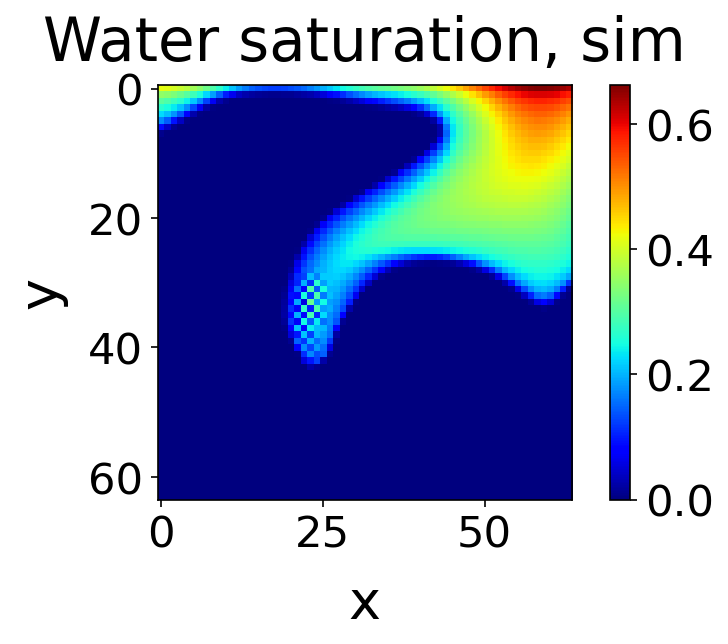

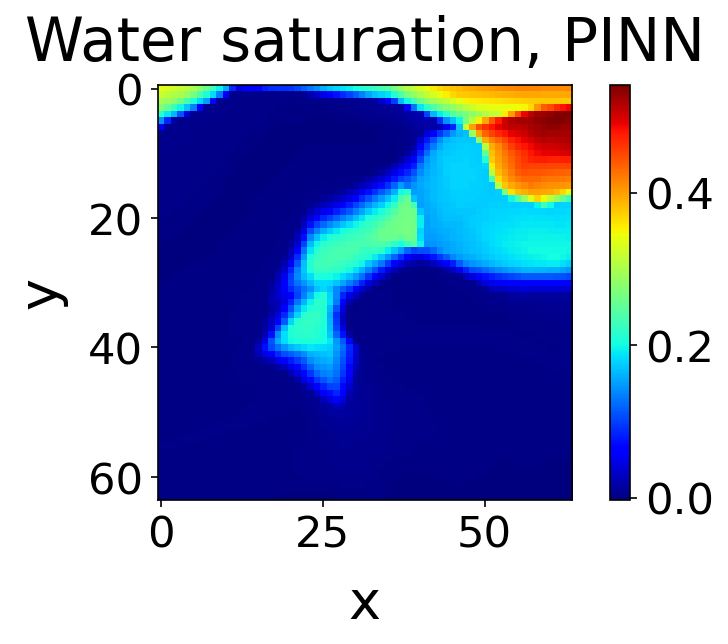

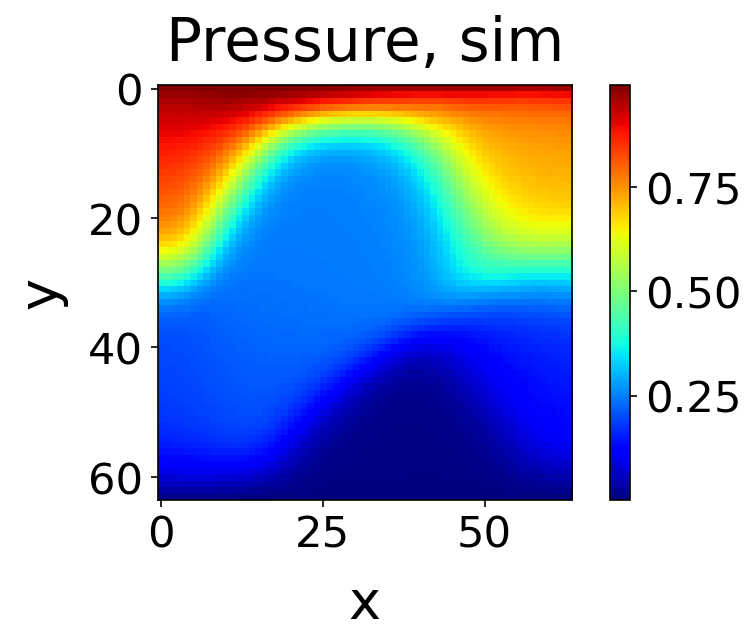

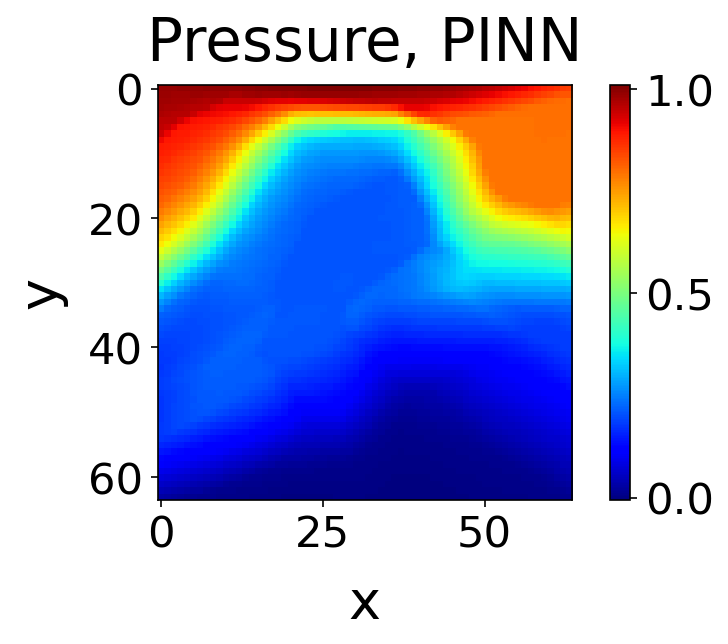

In [27]:
def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

def _add_colorbar_big(im):
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=plt.rcParams.get("ytick.labelsize", 16))
    return cbar

set_big_plot_style(scale=1.3)  # try 1.0 .. 1.6

perm = np.load('perm_3sigma.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

dt = 0.15e-1
niter = 100


# swat = np.zeros((nx0, nx1, nx2))
# soil = np.ones((nx0, nx1, nx2))


# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, dt * niter, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * torch.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1).to('mps'))
model_prediction = model_prediction.cpu().detach().numpy()

    
    
plt.figure()
plt.title('Water saturation, sim')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/satur_sim_test2.png', bbox_inches="tight")
plt.show()

plt.figure()
plt.title('Water saturation, PINN')
plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/satur_pinn_test2.png', bbox_inches="tight")
plt.show()

plt.figure()
plt.title('Pressure, sim')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/pres_sim_test2.png', bbox_inches="tight")
plt.show()


plt.figure()
plt.title('Pressure, PINN')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('graphs/pres_pinn_test2.png', bbox_inches="tight")
plt.show()  

In [86]:
metrics = ['MSE', 'MAE', 'R_2', 'RMSE']

satur = [
    np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1])),
    r2_score(swat[:, 0, 0, -1], model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0] - swat[:, 0, 0, -1]) ** 2))**0.5
]


press = [
    np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2),
    abs(np.mean(model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1])),
    r2_score(pres[:, 0, 0, -1], model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]),
    (np.mean((model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0] - pres[:, 0, 0, -1]) ** 2))**0.5
]

In [87]:
data = pd.DataFrame({'Metrics test': metrics,
                     'Saturation test': satur,
                     'Pressure test': press})

In [88]:
data

,Metrics test,Saturation test,Pressure test
0,MSE,0.000157,0.000220
1,MAE,0.001920,0.004063
2,R_2,0.979666,0.997936
3,RMSE,0.012545,0.014821


# Train results

In [76]:
# Train results
# pres, swat, soil
metrics = ['MSE', 'MAE', 'R_2', 'RMSE']

model_train_pred = model(points).cpu().detach().numpy()
sim_data_train = simulation_data.detach().numpy()

satur = [
    np.mean((model_train_pred[:, 2] - sim_data_train[:, 1]) ** 2),
    abs(np.mean(model_train_pred[:, 2] - sim_data_train[:, 1])),
    r2_score(sim_data_train[:, 1], model_train_pred[:, 2]),
    (np.mean((model_train_pred[:, 2] - sim_data_train[:, 1]) ** 2))**0.5
]


press = [
    np.mean((model_train_pred[:, 0] - sim_data_train[:, 0]) ** 2),
    abs(np.mean(model_train_pred[:, 0] - sim_data_train[:, 0])),
    r2_score(sim_data_train[:, 0], model_train_pred[:, 0]),
    (np.mean((model_train_pred[:, 0] - sim_data_train[:, 0]) ** 2))**0.5
]

In [77]:
data = pd.DataFrame({'Metrics train': metrics,
                     'Saturation train': satur,
                     'Pressure train': press})

data

,Metrics train,Saturation train,Pressure train
0,MSE,0.029610,0.102365
1,MAE,0.086574,0.223145
2,R_2,-0.575527,-0.342077
3,RMSE,0.172075,0.319945


In [45]:
model_prediction[:, 2]

array([ 0.20297553,  0.18941939,  0.17599034, ..., -0.00176622,
       -0.00184536, -0.00193919], dtype=float32)

In [78]:
sim_data_train[:, 1]

array([-5.44713062e-35, -8.53961381e-34, -2.39543708e-36,  2.47118300e-35,
        4.39105915e-35,  5.30774659e-03,  2.26973618e-09,  2.66007066e-01,
       -5.36298139e-33,  3.18020087e-04,  3.65479797e-01, -3.66824767e-34,
        1.91348440e-35,  3.99271786e-01,  3.20196867e-01,  1.07877780e-35,
        2.08822027e-01, -8.84559499e-36,  3.29447573e-33, -2.84698854e-34,
       -7.93899497e-35,  1.23250946e-01,  1.30221533e-05, -2.58770388e-35,
        6.51038363e-06,  6.14137024e-35,  3.61193150e-01, -2.91501440e-33,
        1.37437961e-09,  8.39369092e-03, -1.36051716e-34, -6.81980680e-34,
       -2.80789922e-34, -1.08024698e-33, -5.01120295e-33,  1.43406942e-01,
        1.44964123e-32, -1.35284706e-35,  1.90618164e-34,  3.88702117e-35,
        2.66449305e-34,  2.46853814e-36, -4.73303984e-34, -4.11599347e-35,
       -2.23551108e-34,  4.64662337e-33,  9.76494177e-34,  2.71849036e-01,
        1.36786400e-34, -2.10284184e-34,  3.40055019e-01,  4.20269012e-01,
        1.09593689e-32, -

In [79]:
model_train_pred[:, 2]

array([ 1.70193762e-01,  1.66147351e-01,  8.31827521e-02,  6.08858690e-02,
       -1.91152096e-04,  2.36591399e-01,  1.94048792e-01,  2.43403807e-01,
        1.64687976e-01,  1.91318005e-01,  2.43978798e-01,  1.03926934e-01,
        5.91024756e-03,  2.40260988e-01,  2.43010476e-01,  1.46131217e-03,
        2.37345070e-01,  2.39244878e-01,  2.04917714e-01,  2.29561985e-01,
        1.26147270e-03,  2.36038059e-01,  2.41473317e-01,  7.94987679e-02,
        2.35620886e-01,  2.18681082e-01,  2.37730891e-01,  2.08301157e-01,
        2.19997048e-01,  2.38798305e-01,  2.38406524e-01,  1.59989446e-01,
        2.39027470e-01,  1.90100163e-01,  2.42234007e-01,  2.35784337e-01,
        2.35847861e-01,  1.51500493e-01,  2.37624228e-01,  1.27802640e-02,
        1.82718813e-01,  1.70300901e-03,  2.28362143e-01,  1.27330288e-01,
       -2.06232071e-05,  2.10888177e-01,  5.47388196e-03,  2.46441618e-01,
        4.06682491e-04,  2.17749342e-01,  2.40237534e-01,  2.42527708e-01,
        2.02617109e-01,  

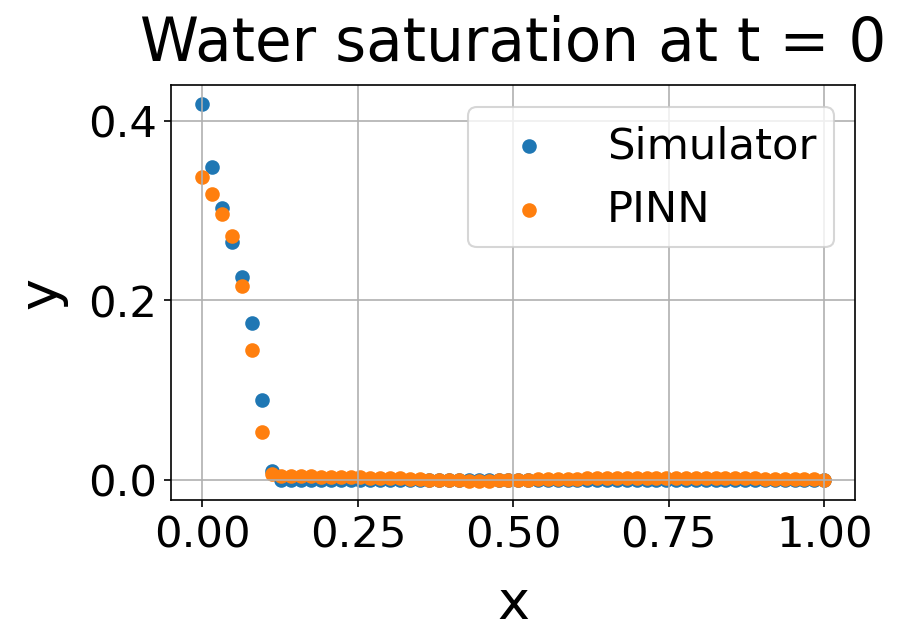

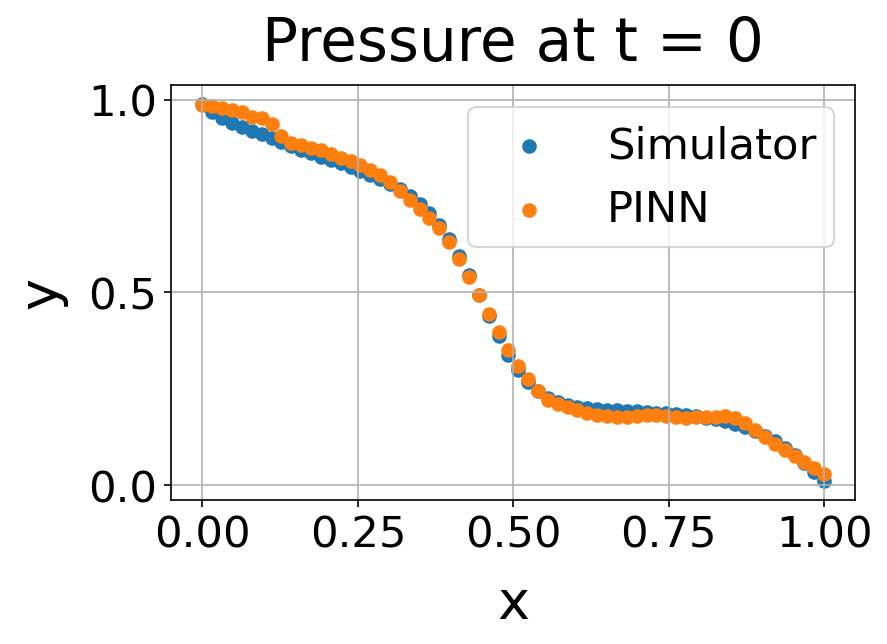

In [28]:
plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.legend()
plt.savefig('third_test/swat_scatter_pinn.png', bbox_inches="tight")
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.legend()
plt.savefig('third_test/pres_scatter_pinn.png', bbox_inches="tight")
plt.show()